In [6]:
import pandas as pd
import numpy as np
import os
import sys
import simpledbf

def getEPHdbf_i(censusstring):
    print ("Downloading", censusstring)
    ### First I will check that it is not already there
    if not os.path.isfile("data/Individual_" + censusstring + ".dbf"):
        if os.path.isfile('Individual_' + censusstring + ".dbf"):
            # if in the current dir just move it
            if os.system("mv " + 'Individual_' + censusstring + ".dbf " + "data/"):
                print ("Error moving file!, Please check!")
        # otherwise start looking for the zip file
        else:
            if not os.path.isfile("data/" + censusstring + "_dbf.zip"):
                if not os.path.isfile(censusstring + "_dbf.zip"):
                    os.system(
                        "curl -O http://www.indec.gob.ar/ftp/cuadros/menusuperior/eph/" + censusstring + "_dbf.zip")
                ###  To move it I use the os.system() functions to run bash commands with arguments
                os.system("mv " + censusstring + "_dbf.zip " + "data/")
            ### unzip the csv
            os.system("unzip " + "data/" + censusstring + "_dbf.zip -d data/")

    if not os.path.isfile("data/" + 'Individual_' + censusstring + ".dbf"):
        print ("WARNING!!! something is wrong: the file is not there!")

    else:
        print ("file in place, creating CSV file")

    trimestre = censusstring

    dbf = simpledbf.Dbf5('data/Individual_' + trimestre + '.dbf',codec='latin1')
    indRaw = dbf.to_dataframe()

    indNoW = indRaw.loc[indRaw.REGION == 1,['CODUSU',
                        'NRO_HOGAR',
                        'PONDERA',
                        'CH03',
                        'CH04',
                        'CH06',
                        'CH07',
                        'CH15',
                        'NIVEL_ED',
                        'ESTADO',
                        'CAT_OCUP',
#                         'ITF',
#                         'IPCF',
                        'P47T']]

    indNoW.columns = ['CODUSU',
                        'NRO_HOGAR',
                        'PONDERA',
                        'Parentesco',
                        'Sexo',
                        'Edad',
                        'Estado_Civil',
                        'Lugar_Nac',
                        'NIVEL_ED',
                        'Trabajo',
                        'CAT_OCUP',
#                         'Ingr_Total_Fam',
#                         'Ingr_Per_Capita_Fam',
                        'Ingr_Total_Ind']
    indNoW.index =range(0,indNoW.shape[0])

    indNoW.to_csv('data/cleanData' + trimestre + '.csv', index = False)
    print 'csv file cleanData',trimestre,'.csv successfully created in folder data/'
    return

In [7]:
def dummy_variables(data, data_type_dict):
    #Loop over nominal variables.
    for variable in filter(lambda x: data_type_dict[x]=='nominal',
                           data_type_dict.keys()):
 
        #First we create the columns with dummy variables.
        #Note that the argument 'prefix' means the column names will be
        #prefix_value for each unique value in the original column, so
        #we set the prefix to be the name of the original variable.
        dummy_df=pd.get_dummies(data[variable], prefix=variable)
 
        #Remove old variable from dictionary.
        data_type_dict.pop(variable)
 
        #Add new dummy variables to dictionary.
        for dummy_variable in dummy_df.columns:
            data_type_dict[dummy_variable] = 'nominal'
 
        #Add dummy variables to main df.
        data=data.drop(variable, axis=1)
        data=data.join(dummy_df)
 
    return [data, data_type_dict]

In [69]:
def make_dummy(data):
    data['edad-sexo'] = 'no-data'
    data.loc[(data['Sexo'] == 0) & (data['Edad'] < 14), 'edad-sexo'] = 'male_0_14'
    data.loc[(data['Sexo'] == 0) & (data['Edad'] >= 14) & (data['Edad'] < 25), 'edad-sexo'] = 'male_14_24'
    data.loc[(data['Sexo'] == 0) & (data['Edad'] >= 25) & (data['Edad'] < 35), 'edad-sexo'] = 'male_25_34'
    data.loc[(data['Sexo'] == 0) & (data['Edad'] >= 35), 'edad-sexo'] = 'male_35_more'
    data.loc[(data['Sexo'] == 1) & (data['Edad'] < 14), 'edad-sexo'] = 'female_0_14'
    data.loc[(data['Sexo'] == 1) & (data['Edad'] >= 14) & (data['Edad'] < 25), 'edad-sexo'] = 'female_14_24'
    data.loc[(data['Sexo'] == 1) & (data['Edad'] >= 25) & (data['Edad'] < 35), 'edad-sexo'] = 'female_25_34'
    data.loc[(data['Sexo'] == 1) & (data['Edad'] >= 35), 'edad-sexo'] = 'female_35_more'
    return

In [73]:
getEPHdbf_i('t310')

('Downloading', 't310')
file in place, creating CSV file
csv file cleanData t310 .csv successfully created in folder data/


In [126]:
data = pd.read_csv('data/cleanDatat310.csv')
data.head()

,CODUSU,NRO_HOGAR,PONDERA,Parentesco,Sexo,Edad,Estado_Civil,Lugar_Nac,NIVEL_ED,Trabajo,CAT_OCUP,Ingr_Total_Ind
0,302468,1,1287,1,2,20,5,1,5,3,0,2000
1,302468,1,1287,10,2,20,5,1,5,3,0,2000
2,307861,1,1674,1,1,42,2,2,2,1,3,3000
3,307861,1,1674,2,2,44,2,2,6,1,3,2800
4,307861,1,1674,3,1,13,5,1,3,3,0,0


In [127]:
cols = data.columns.tolist()
cols = cols[-1:] + cols[:-1]
data = data[cols]

In [128]:
data['Parentesco'] = data['Parentesco'].map({1:'Jefe', 2:'Conyuge', 3:'Hijo',4:'Yerno',5:'Nieto', 6:'Madre-padre',
                                             7:'Suegro', 8:'Hermano',9:'Otro', 10:'No-familia'})
data['Sexo'] = data['Sexo'].map({1:0,2:1})
data['Estado_Civil'] = data['Estado_Civil'].map({1:'Unido',2:'Casado',3:'Divorciado',4:'Viudo',5:'Soltero'})
data.Estado_Civil.replace(to_replace=[9], value=[np.nan], inplace=True, axis=None) 
data['Lugar_Nac'] = data['Lugar_Nac'].map({1:'Localidad',2:'Otra_loc',3:'Otra_prov',4:'Pais_limit',5:'Otro_pais'})
data.Lugar_Nac.replace(to_replace=[9], value=[np.nan], inplace=True, axis=None) 
data['NIVEL_ED'] = data['NIVEL_ED'].map({1:'Primaria_I',2:'Primaria_C',3:'Secundaria_I',4:'Secundaria_C',
                                          5:'Univ_I',6:'Univ_C',7:'Sin_Edu'})
data['Trabajo'] = data['Trabajo'].map({1:'Ocupado',2:'Desocupado',3:'Inactivo',4:'Menor'})
data.Trabajo.replace(to_replace=[0], value=[np.nan], inplace=True, axis=None) 
data['CAT_OCUP'] = data['CAT_OCUP'].map({0:'No_empleo',1:'Patron',2:'Cuenta_propia', 3:'Empleado',4:'Sin_sueldo'})

In [129]:
make_dummy(data)

In [130]:
data_type_dict = {'Parentesco':'nominal','Estado_Civil':'nominal','Lugar_Nac':'nominal','NIVEL_ED':'nominal',
                 'Trabajo':'nominal','CAT_OCUP':'nominal'}
dummy_var = dummy_variables(data, data_type_dict)
df = dummy_var[0]

In [131]:
df = df.drop('edad-sexo', axis=1)

In [132]:
df.head()

,Ingr_Total_Ind,CODUSU,NRO_HOGAR,PONDERA,Sexo,Edad,Parentesco_Conyuge,Parentesco_Hermano,Parentesco_Hijo,Parentesco_Jefe,...,Estado_Civil_Viudo,Lugar_Nac_Localidad,Lugar_Nac_Otra_loc,Lugar_Nac_Otra_prov,Lugar_Nac_Otro_pais,Lugar_Nac_Pais_limit,Trabajo_Desocupado,Trabajo_Inactivo,Trabajo_Menor,Trabajo_Ocupado
0,2000,302468,1,1287,1,20,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2000,302468,1,1287,1,20,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,3000,307861,1,1674,0,42,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2800,307861,1,1674,1,44,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0,307861,1,1674,0,13,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [122]:
# Run linear regression
x=df.iloc[:,1:]
y=np.asarray(df.Ingr_Total_Ind)
# weights=np.asarray(df.PONDERA)
# df = df.drop('PONDERA', axis=1)
weights_train = weights[:5016]

In [124]:
# sk-learn (Y ~ x) with intercept
from sklearn.linear_model import LinearRegression

R_IS=[]
R_OS=[]

n = 100
from sklearn.cross_validation import train_test_split
for i in range(n):
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.40)
    
    res=LinearRegression(fit_intercept=False)
    res.fit(X_train,y_train,sample_weight=weights_train)
    R_IS.append(1-((np.asarray(res.predict(X_train))-y_train)**2).sum()/((y_train-np.mean(y_train))**2).sum())                                                                     
    R_OS.append(1-((np.asarray(res.predict(X_test))-y_test)**2).sum()/((y_test-np.mean(y_test))**2).sum())
    
print("IS R-squared for {} times is {}".format(n,np.mean(R_IS)))
print("OS R-squared for {} times is {}".format(n,np.mean(R_OS)))

IS R-squared for 100 times is 0.491594989235
OS R-squared for 100 times is 0.48973903576


In [26]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification
from sklearn.datasets import make_blobs
from matplotlib.pylab import plt
%matplotlib inline

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


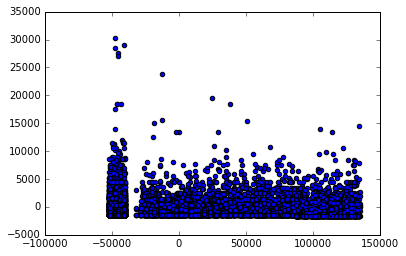

In [125]:
from sklearn.decomposition import PCA
import matplotlib.pylab as plt

pca = PCA(2)
Xproj = pca.fit_transform(df)
plt.scatter(Xproj[:,0],Xproj[:,1])
plt.show()

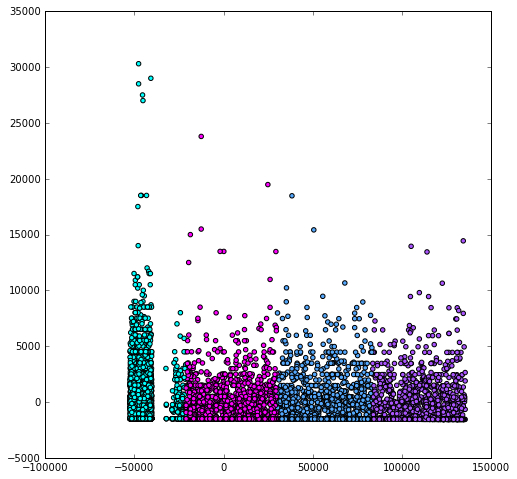

In [112]:
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans

X3 = np.asarray(df)

Xproj2 = pca.fit_transform(df)

km1=KMeans(n_clusters = 4, random_state = 324)
res5=km1.fit(X3)

plt.figure(figsize=(8,8))

plt.scatter(Xproj2[:, 0], Xproj2[:, 1], c=res5.predict(X3), cmap=plt.cm.cool)
plt.show()

In [114]:
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans

X = np.asarray(df)
range_n_clusters = [2, 3, 4, 5, 6, 7]
for n_clusters in range_n_clusters:
    km = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters = {},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

For n_clusters = 2, the average silhouette_score is :0.741589321074
For n_clusters = 3, the average silhouette_score is :0.724995299497
For n_clusters = 4, the average silhouette_score is :0.716886263101
For n_clusters = 5, the average silhouette_score is :0.7119781235
For n_clusters = 6, the average silhouette_score is :0.697278095436
For n_clusters = 7, the average silhouette_score is :0.689042684383


In [133]:
df.to_csv('data_sobre_EPH.csv', index = False)